# Clean Users Analysis

Users are scraped using the `baseline-user-ids.json` input (a list of User IDs) in `twitter_scraper.scrape` - at this point, Users' locations aren't restricted to Croatia only as they will be filtered using the `twitter_scraper.clean` module.

This module reads the scraped User data and filters it by:

* *protected* = False
* *is_croatian* = True
* *statuses_count* > 10
* *friends_count* > 10
* *friends_count* < 5000
* *followers_count* > 10
* *followers_count* < 5000

Resulting with the following data schema:

Column           | Description                                                          | Data Type   
---------------- | -------------------------------------------------------------------- | ------- 
user_id          | Numeric user identifier                                              | int64
created_at       | The UTC datetime that the user account was created on Twitter        | datetime64[ns, UTC]
screen_name      | Alphabetic user identifier                                           | string  
location         | User submitted location                                              | string  
description      | User submitted description                                           | string  
protected        | User allows public access to his profile                             | boolean 
verified         | User is verified by Twitter ([Verified Accounts](https://help.twitter.com/en/managing-your-account/about-twitter-verified-accounts))                                                       | boolean 
followers_count  | Number of accounts that follow the user                              | int64   
friends_count    | Number of accounts that the user follows                             | int64   
listed_count     | Number of public lists that this user is a member of                 | int64   
favourites_count | The number of Tweets this user has liked in the account's lifetime   | int64   
statuses_count   | The number of Tweets (including retweets) issued by the user         | int64   
is_croatian      | Custom value indicating the user's location is Croatian              | bool    
clean_location   | Custom value, aims to pinpoint a Croatian location                   | string  

## Interpreting Croatian Twitter Users

The "Clean Users Analysis" answers the following questions:

* What is the most common Croatian Users location?
* Who are Croatian Users that tweet the most (all-time number of tweets)? Are they verified?
* Which Croatian users are followed the most? 
* Which Croatian users like other tweets the most?

In [162]:
from twitter_scraper.clean.users import USER_DTYPE
from twitter_scraper.clean.tweets import TWEET_DTYPE
from twitter_scraper import settings
from twitter_scraper import utils

import matplotlib.pyplot as plt
import datetime as dt
import pandas as pd

import matplotlib.style
import matplotlib as mpl

mpl.style.use('seaborn-v0_8-darkgrid')
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


ANALYSIS_MIN_DATE = dt.datetime.fromisoformat('2022-10-01T00:00:00+00:00')
ANALYZE_COLUMNS = [
    'name',
    'screen_name',
    'location',
    'is_croatian',
    'description',
    
    'followers_count',
    'friends_count',
    'favourites_count',
    'favorite_cnt', # sum by tweet favorite_count
    'statuses_count',
    
    'total_tweets_cnt',
    'original_tweets_cnt',
    'original_tweets_pct',
    'retweet_tweets_cnt',
    'retweet_tweets_pct',
    'reply_tweets_cnt',
    'reply_tweets_pct',
    'quote_tweets_cnt',
    'quote_tweets_pct',
    
    'protected',
    'verified',
    'created_at',
    'clean_location'
]

clean_users_dfs = utils.read_directory_files(
    directory=settings.CLEAN_USERS_DIR, 
    read_fn=pd.read_csv, 
    dtype=USER_DTYPE,
    parse_dates=['created_at']
)
clean_tweets_dfs = utils.read_directory_files(
    directory=settings.CLEAN_TWEETS_DIR, 
    read_fn=pd.read_csv, 
    dtype=TWEET_DTYPE,
    parse_dates=['created_at', 'retweet_created_at']
)

users_df = pd.concat(clean_users_dfs).set_index('user_id')
tweets_df = pd.concat(clean_tweets_dfs).drop_duplicates('id')
tweets_df = tweets_df.loc[tweets_df['created_at'] > ANALYSIS_MIN_DATE].drop_duplicates(subset='id')
tweets_df['year'] = tweets_df.created_at.dt.year
tweets_df['mon'] = tweets_df.created_at.dt.month
tweets_df['day'] = tweets_df.created_at.dt.day

In [163]:
tweets__user_gdf = tweets_df.groupby('user_id').agg(
    total_tweets_cnt=('id', 'size'),
    retweet_tweets_cnt=('is_retweet', 'sum'),
    reply_tweets_cnt=('is_reply', 'sum'),
    quote_tweets_cnt=('is_quote_status', 'sum'),
    favorite_cnt=('favorite_count', 'sum')
)
tweets__user_gdf['original_tweets_cnt'] = tweets__user_gdf['total_tweets_cnt'] - (tweets__user_gdf['retweet_tweets_cnt'] + tweets__user_gdf['reply_tweets_cnt'])
tweets__user_gdf['original_tweets_pct'] = tweets__user_gdf.apply(lambda row: row.original_tweets_cnt / row.total_tweets_cnt if row.original_tweets_cnt > 0 else 0, axis=1)
tweets__user_gdf['retweet_tweets_pct'] = tweets__user_gdf['retweet_tweets_cnt'] / tweets__user_gdf['total_tweets_cnt']
tweets__user_gdf['reply_tweets_pct'] = tweets__user_gdf['reply_tweets_cnt'] / tweets__user_gdf['total_tweets_cnt']
tweets__user_gdf['quote_tweets_pct'] = tweets__user_gdf['quote_tweets_cnt'] / tweets__user_gdf['total_tweets_cnt']

users_df['total_tweets_cnt'] = tweets__user_gdf['total_tweets_cnt'].astype(int)
users_df['original_tweets_cnt'] = tweets__user_gdf['original_tweets_cnt'].astype(int).fillna(0)
users_df['original_tweets_pct'] = tweets__user_gdf['original_tweets_pct'].fillna(0)
users_df['retweet_tweets_cnt'] = tweets__user_gdf['retweet_tweets_cnt'].astype(int).fillna(0)
users_df['retweet_tweets_pct'] = tweets__user_gdf['retweet_tweets_pct'].fillna(0)
users_df['reply_tweets_cnt'] = tweets__user_gdf['reply_tweets_cnt'].astype(int).fillna(0)
users_df['reply_tweets_pct'] = tweets__user_gdf['reply_tweets_pct'].fillna(0)
users_df['quote_tweets_cnt'] = tweets__user_gdf['quote_tweets_cnt'].astype(int).fillna(0)
users_df['quote_tweets_pct'] = tweets__user_gdf['quote_tweets_pct'].fillna(0)
users_df['favorite_cnt'] = tweets__user_gdf['favorite_cnt'].fillna(0).astype(int)

users_df = users_df[ANALYZE_COLUMNS]
# ana88cro,1122522158486499329

In [156]:
_users_df = users_df
_users_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32368 entries, 141690464 to 2723414012
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   name                 32364 non-null  string             
 1   screen_name          32368 non-null  string             
 2   location             32354 non-null  string             
 3   is_croatian          32368 non-null  bool               
 4   description          25237 non-null  string             
 5   followers_count      32368 non-null  int64              
 6   friends_count        32368 non-null  int64              
 7   favourites_count     32368 non-null  int64              
 8   favorite_cnt         6188 non-null   float64            
 9   statuses_count       32368 non-null  int64              
 10  total_tweets_cnt     6188 non-null   float64            
 11  original_tweets_cnt  6188 non-null   float64            
 12  origi

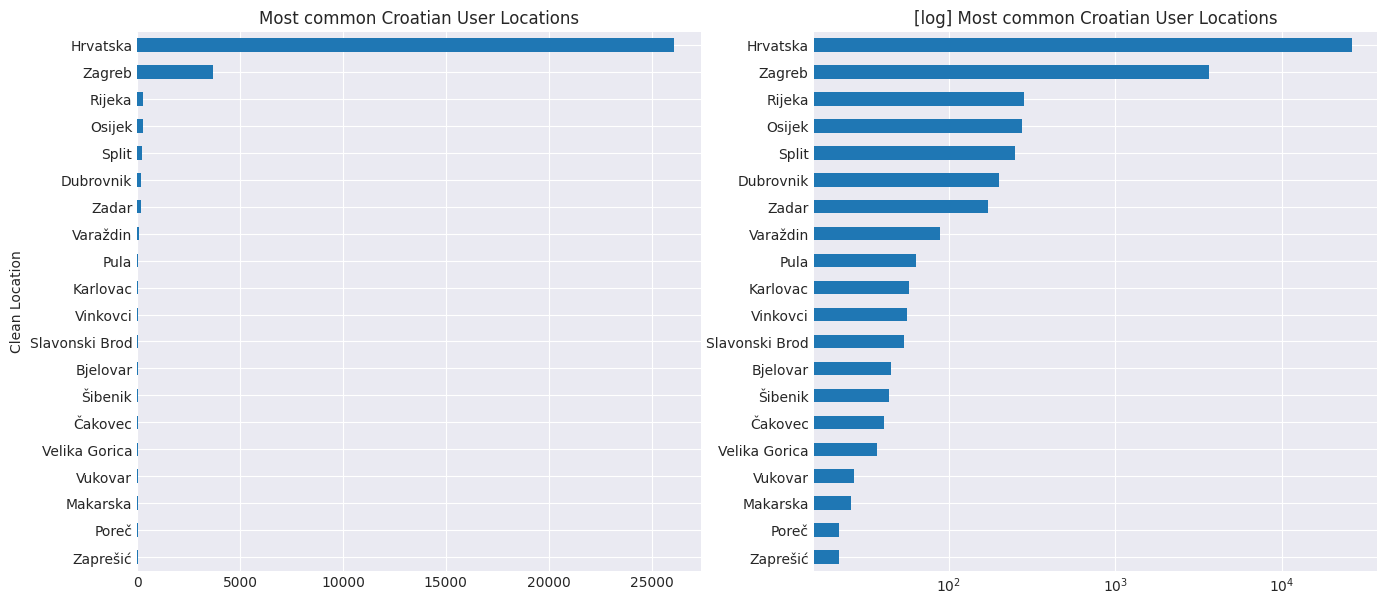

In [157]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 7))

location_df = _users_df.groupby('clean_location').size().sort_values()
# location_df.drop(['Hrvatska', '🇭🇷', 'Zg'], inplace=True)
location_df.tail(20).plot.barh(ax=axs[0])

axs[0].set_title('Most common Croatian User Locations')
axs[0].set_ylabel('Clean Location')

location_df.tail(20).plot.barh(ax=axs[1])

axs[1].set_title('[log] Most common Croatian User Locations')
axs[1].set_ylabel(None)
axs[1].set_xscale('log')
plt.show()

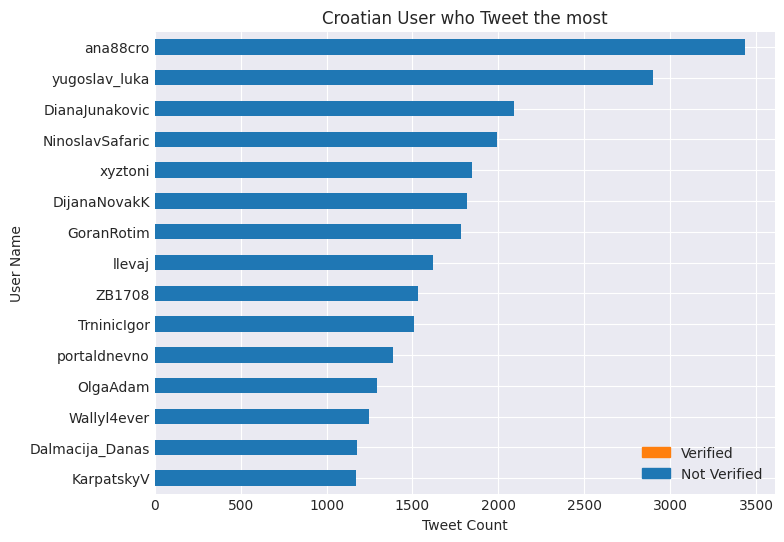

,location,description
screen_name,,
ana88cro,Croatia🇭🇷Zadar🇭🇷,🔞ADULT ONLY 🔞
yugoslav_luka,"Zagreb, Croatia","Interest in military hardware, geopolitics and..."
DianaJunakovic,Republic of Croatia,"Award Winning Photographer from Split, Croatia..."
NinoslavSafaric,Zagreb,"Nihil enim est opertum, quod non revelabitur, ..."
xyztoni,Republic of Croatia,Degenerate turned Web3 Degenerate
DijanaNovakK,"Zagreb, Croatia",Creative 🐉 ✏️〰️🚀 KO FND OS OBJKT 🦾🤖AI creative...
GoranRotim,Zagreb,journalist at HRT
llevaj,Croatia,"Only two things are infinite, the universe and..."
ZB1708,Zadar,""" Bijah, jesam, bit ću"""


In [150]:
import matplotlib.patches as mpatches

fig, ax = plt.subplots(1, figsize=(8, 6))

most_tweeters_df = _users_df[['screen_name', 'location', 'description', 'verified', 'total_tweets_cnt']] \
  .set_index('screen_name').sort_values(by='total_tweets_cnt')
most_tweeters_df['color'] = most_tweeters_df['verified'].transform(lambda x: default_colors[1] if x else default_colors[0])
most_tweeters_df['total_tweets_cnt'].tail(15).plot.barh(ax=ax, color=most_tweeters_df.tail(15)['color'])

ax.set_title('Croatian User who Tweet the most')
ax.set_xlabel('Tweet Count')
ax.set_ylabel('User Name')

VER = mpatches.Patch(color=default_colors[1], label='Verified')
NOT_VER = mpatches.Patch(color=default_colors[0], label='Not Verified')
ax.legend(handles=[VER, NOT_VER])

plt.show()
most_tweeters_df[['location', 'description']].tail(15).iloc[::-1]

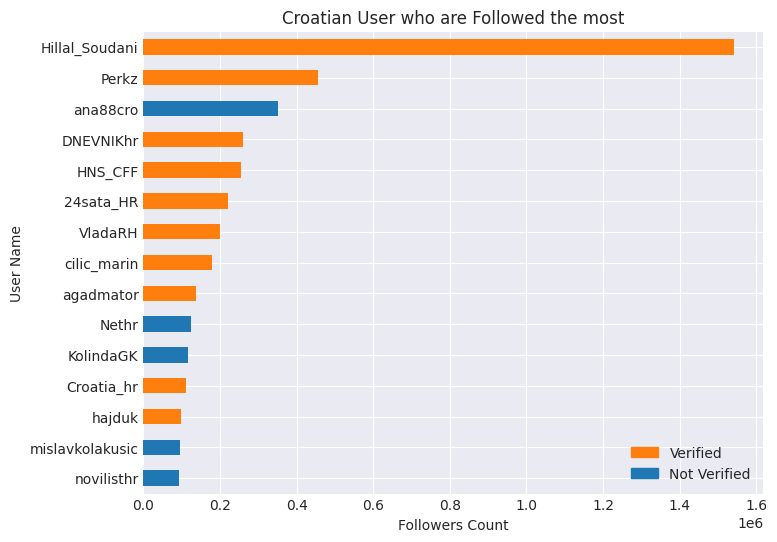

,location,description
screen_name,,
Hillal_Soudani,"Zagreb,croatie",Professional Footballer 2️⃣- Currently playing...
Perkz,Croatia,🇭🇷 24 years old. Professional League of Legend...
ana88cro,Croatia🇭🇷Zadar🇭🇷,🔞ADULT ONLY 🔞
DNEVNIKhr,Republic of Croatia,Saznajte prvi najvažnije informacije #dnevnikhr
HNS_CFF,Hrvatska | Croatia,Službeni Twitter profil Hrvatskog nogometnog s...
24sata_HR,"Zagreb, Croatia",dnevna doza tweetova s našeg portala
VladaRH,Croatia,Vlada Republike Hrvatske - službeni Twitter ra...
cilic_marin,Croatia,Professional tennis player 🎾
agadmator,Republic of Croatia,Owner and content creator of agadmator's Chess...


In [151]:
fig, ax = plt.subplots(1, figsize=(8, 6))

most_tweeters_df = _users_df[['screen_name', 'location', 'description', 'verified', 'followers_count']] \
  .set_index('screen_name').sort_values(by='followers_count')
most_tweeters_df['color'] = most_tweeters_df['verified'].transform(lambda x: default_colors[1] if x else default_colors[0])
most_tweeters_df['followers_count'].tail(15).plot.barh(ax=ax, color=most_tweeters_df.tail(15)['color'])

ax.set_title('Croatian User who are Followed the most')
ax.set_xlabel('Followers Count')
ax.set_ylabel('User Name')

VER = mpatches.Patch(color=default_colors[1], label='Verified')
NOT_VER = mpatches.Patch(color=default_colors[0], label='Not Verified')
ax.legend(handles=[VER, NOT_VER])

plt.show()
most_tweeters_df[['location', 'description']].tail(15).iloc[::-1]


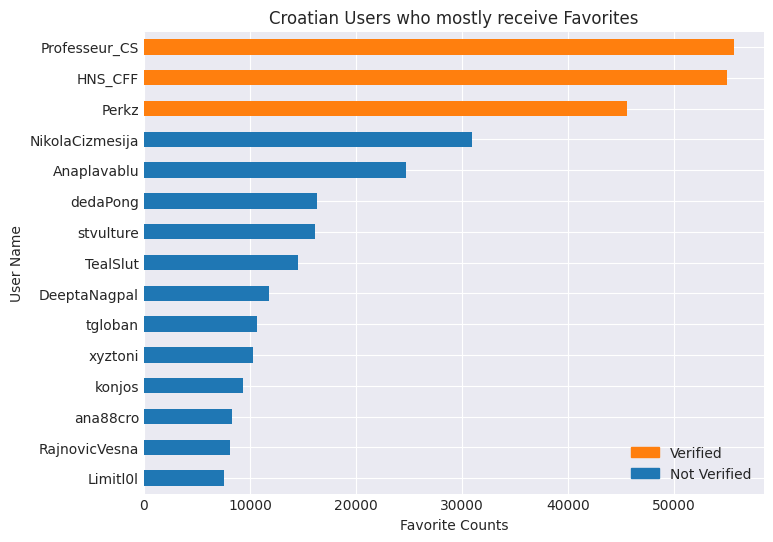

,location,description
screen_name,,
Professeur_CS,"Split, Croatia",Head of Operations @hltvorg @HLTVconfirmed co...
HNS_CFF,Hrvatska | Croatia,Službeni Twitter profil Hrvatskog nogometnog s...
Perkz,Croatia,🇭🇷 24 years old. Professional League of Legend...
NikolaCizmesija,Croatia,Comic and illustration artist at DC comics Sw...
Anaplavablu,Zagreb,Purgerica…relativno normalna…volim sve nijanse...
dedaPong,Zagreb,Co-Founder / Creative Director at Gamepires ht...
stvulture,croatia,<NA>
TealSlut,Croatia,2020 gonna be my year. @tealslutpriv
DeeptaNagpal,"India, Croatia",Founder & Chief Dietitian - Beyond Kilos & Inc...


In [114]:
fig, ax = plt.subplots(1, figsize=(8, 6))

most_tweeters_df = _users_df[['screen_name', 'location', 'description', 'verified', 'favorite_cnt']] \
  .set_index('screen_name').sort_values(by='favorite_cnt')
most_tweeters_df['color'] = most_tweeters_df['verified'].transform(lambda x: default_colors[1] if x else default_colors[0])
most_tweeters_df['favorite_cnt'].tail(15).plot.barh(ax=ax, color=most_tweeters_df.tail(15)['color'])

ax.set_title('Croatian Users who mostly receive Favorites')
ax.set_xlabel('Favorite Counts')
ax.set_ylabel('User Name')

VER = mpatches.Patch(color=default_colors[1], label='Verified')
NOT_VER = mpatches.Patch(color=default_colors[0], label='Not Verified')
ax.legend(handles=[VER, NOT_VER])

plt.show()
most_tweeters_df[['location', 'description']].tail(15).iloc[::-1]


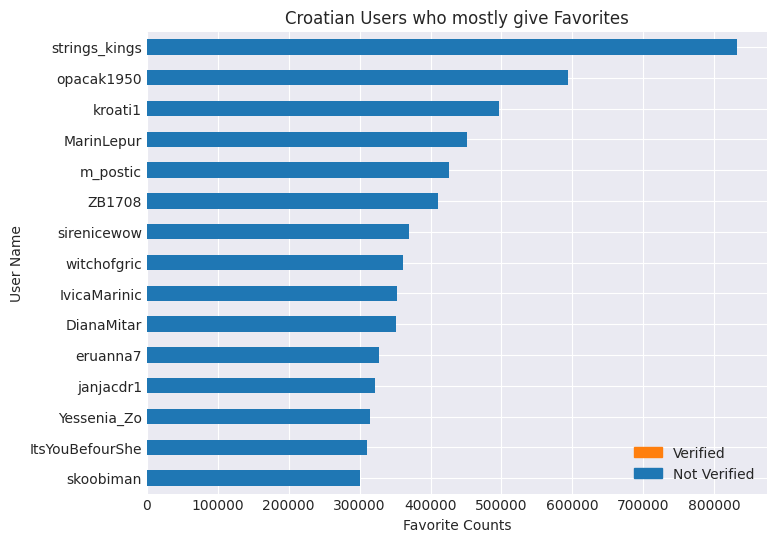

,location,description
screen_name,,
strings_kings,"Zagreb, Croatia",free style. quick observation. no sorry.
opacak1950,"Republic of Croatia, Osijek","26 years old. Volim Hajduk, sport, filmove i k..."
kroati1,Croatia / Mateus,FFXIV-posting│ Please listen to my advice │SFS...
MarinLepur,"Zadar, Republic of Croatia",22 | Future starving artist
m_postic,Zagreb,"Ja sam ovaj desni, ali samo na slici, politick..."
ZB1708,Zadar,""" Bijah, jesam, bit ću"""
sirenicewow,"Zagreb, Croatia",Cada esquina de este circulo al revés. ...
witchofgric,"Zagreb, Croatia","Wife, mom, reader, music lover (and a kitchen ..."
IvicaMarinic,Republic of Croatia,Firefull beleiver in Jesus Christ!!


In [115]:
fig, ax = plt.subplots(1, figsize=(8, 6))

most_tweeters_df = _users_df[['screen_name', 'location', 'description', 'verified', 'favourites_count']] \
  .set_index('screen_name').sort_values(by='favourites_count')
most_tweeters_df['color'] = most_tweeters_df['verified'].transform(lambda x: default_colors[1] if x else default_colors[0])
most_tweeters_df['favourites_count'].tail(15).plot.barh(ax=ax, color=most_tweeters_df.tail(15)['color'])

ax.set_title('Croatian Users who mostly give Favorites')
ax.set_xlabel('Favorite Counts')
ax.set_ylabel('User Name')

VER = mpatches.Patch(color=default_colors[1], label='Verified')
NOT_VER = mpatches.Patch(color=default_colors[0], label='Not Verified')
ax.legend(handles=[VER, NOT_VER])

plt.show()
most_tweeters_df[['location', 'description']].tail(15).iloc[::-1]


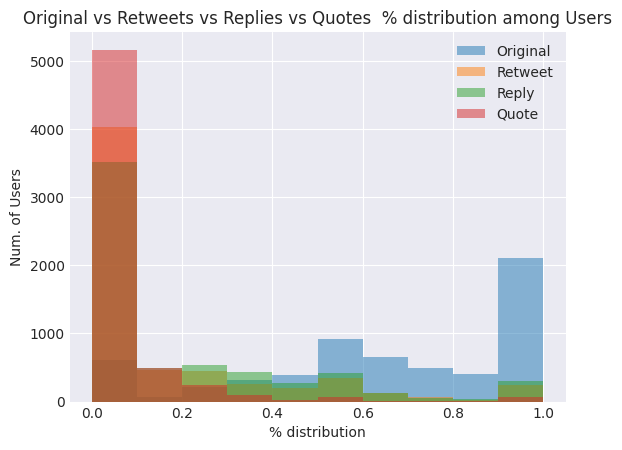

In [165]:

ax = _users_df[['original_tweets_pct', 'retweet_tweets_pct', 'reply_tweets_pct', 'quote_tweets_pct']].plot.hist(alpha=0.5)
# _users_df['retweet_tweets_pct'].hist(ax=ax, log=False, color=default_colors[1])
ax.set_title('Original vs Retweets vs Replies vs Quotes  % distribution among Users')
ax.set_ylabel('Num. of Users')
ax.set_xlabel('% distribution')
ax.legend(['Original', 'Retweet', 'Reply', 'Quote'])
plt.show()

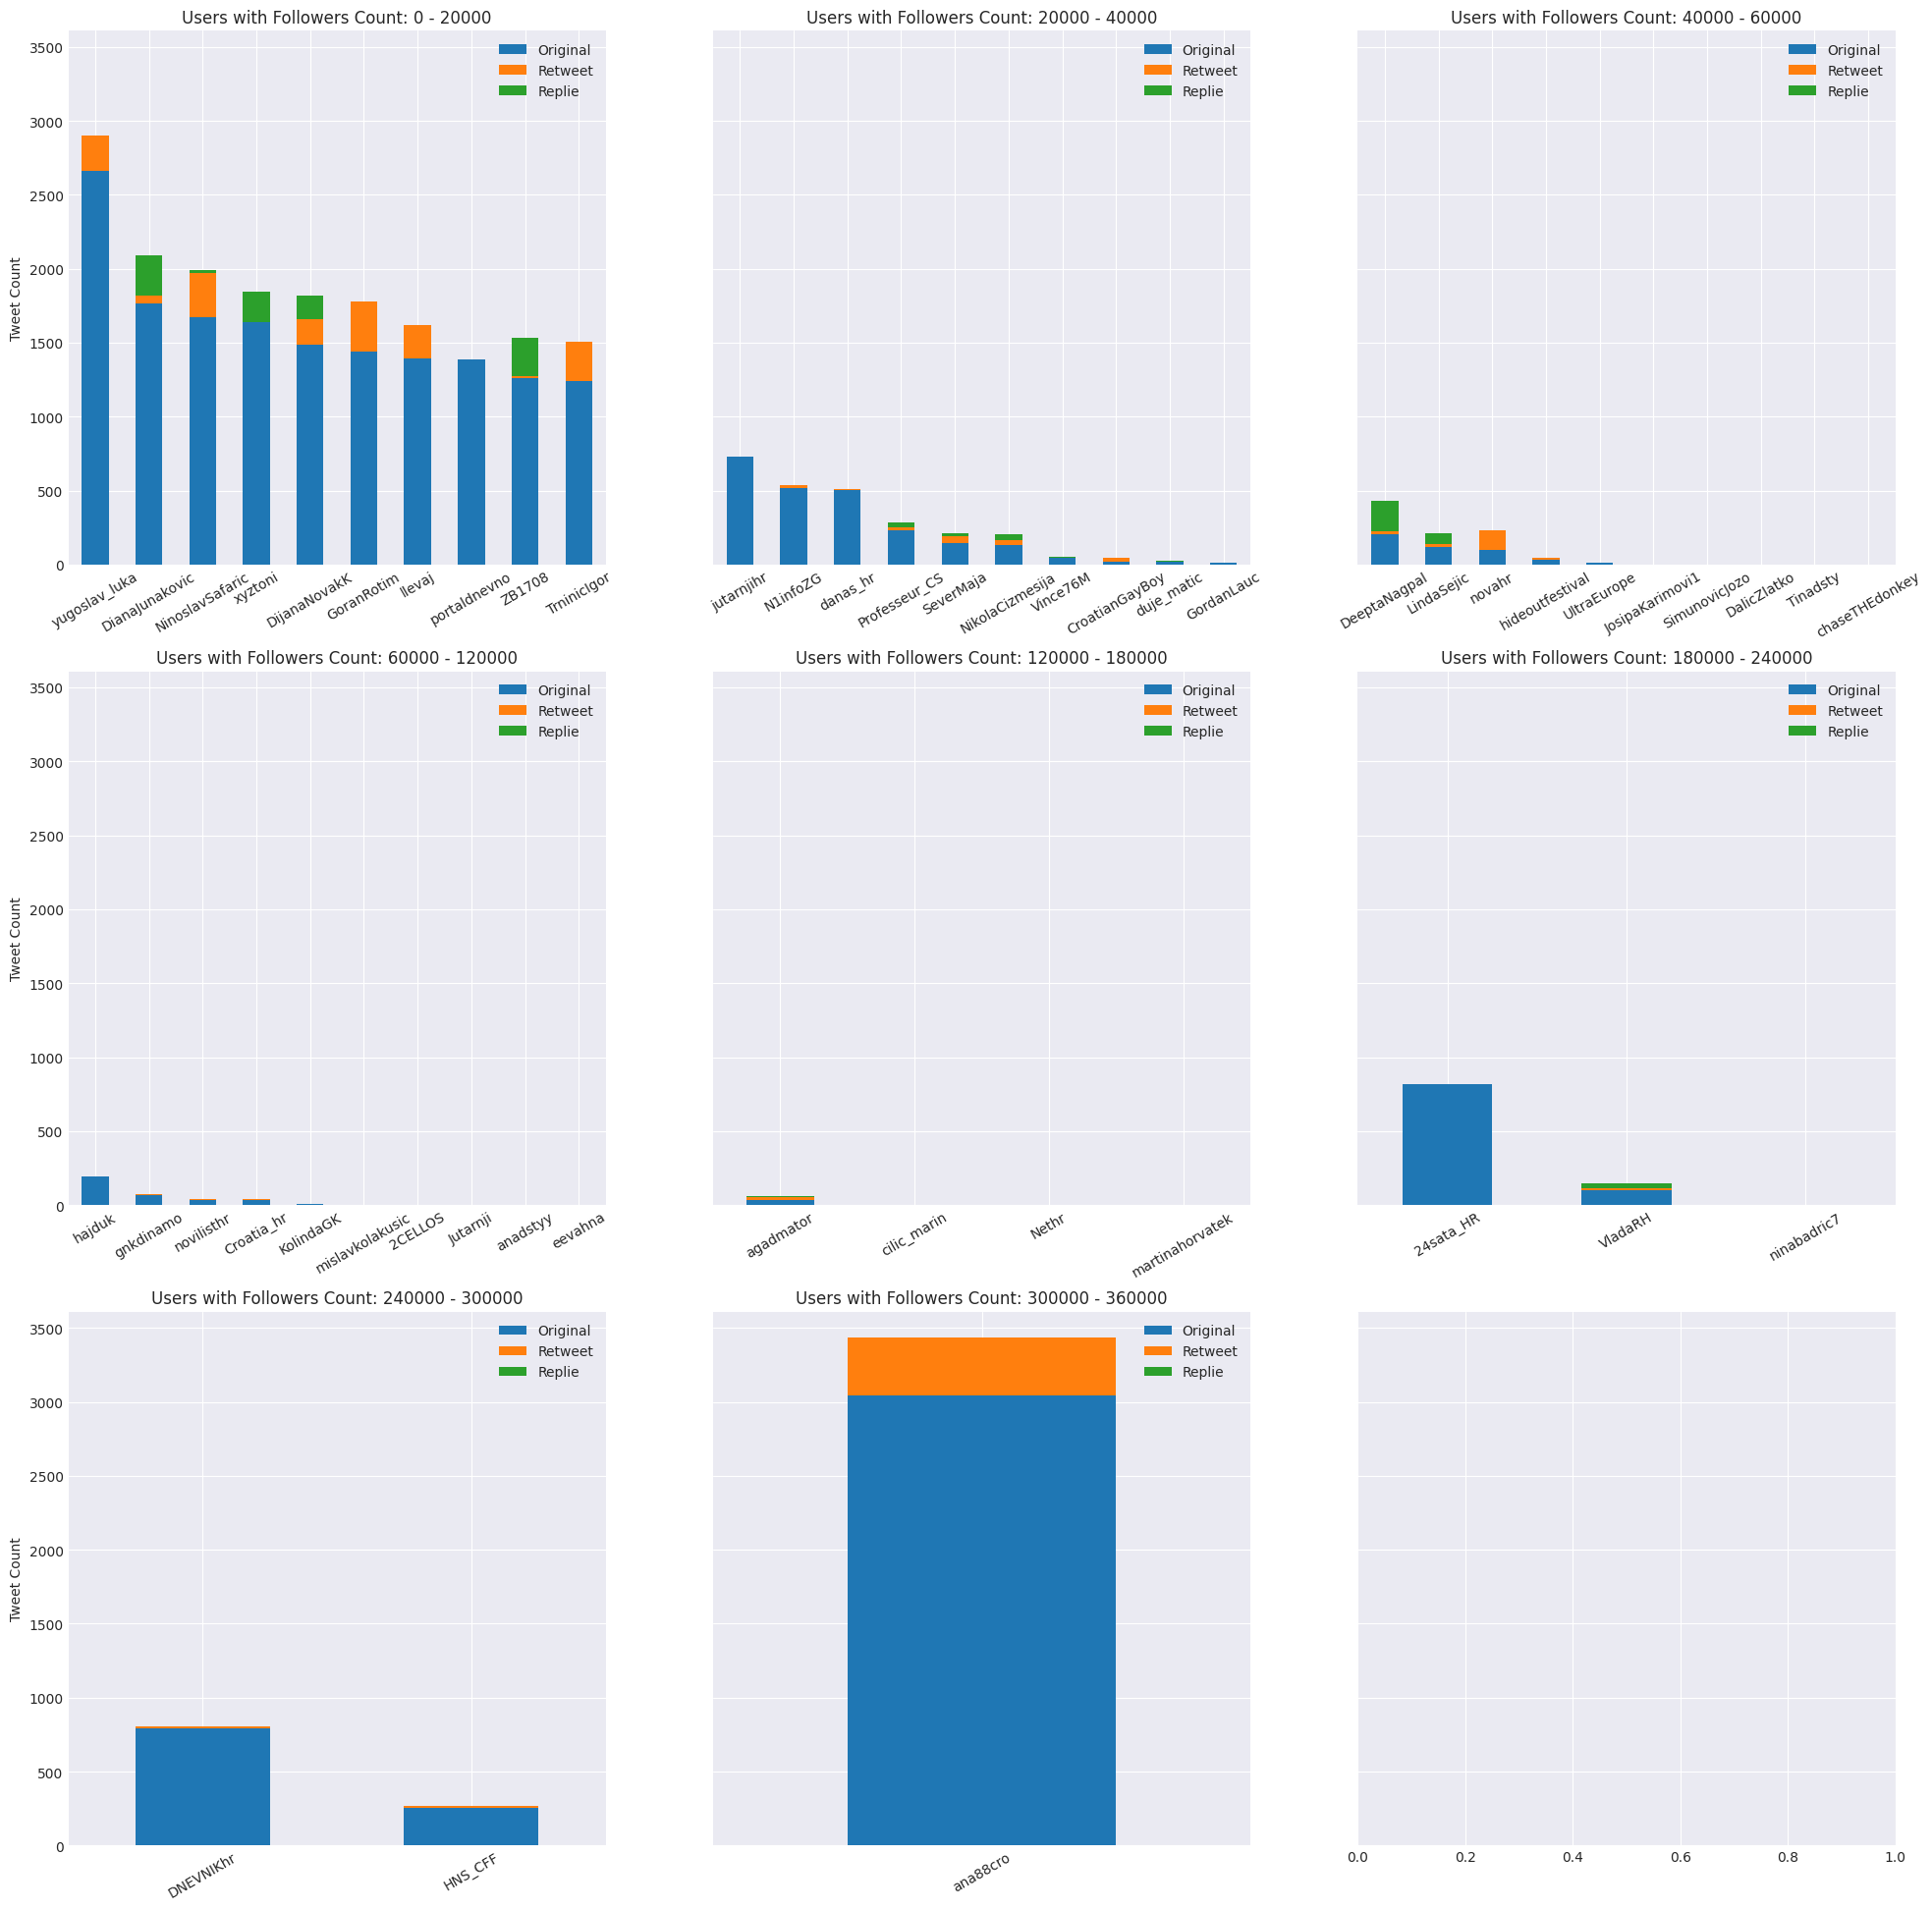

In [168]:
from math import ceil

title = 'Monthy ratio between Retweets, Replies and Original Tweets'

upper_limit = 350_000
step_1 = 20_000
step_2 = 60_000

ncols = 3
nrows = ceil(step_2/step_1/ncols) + ceil(upper_limit/step_2/ncols)
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, sharey=True, figsize=(ncols*8, nrows*8))

i, j = 0, 0
for limit in range(0, step_2, step_1):
    if j == ncols: j = 0; i += 1
    
    _users_df[
        (_users_df['followers_count'] > limit)
        & (_users_df['followers_count'] < limit+step_1)
    ][['original_tweets_cnt', 'retweet_tweets_cnt', 'reply_tweets_cnt']] \
        .sort_values('original_tweets_cnt', ascending=False) \
        .head(10).rename(
            columns={
                'original_tweets_cnt': 'Original',
                'retweet_tweets_cnt': 'Retweet',
                'reply_tweets_cnt': 'Replie'
            }
        ).plot.bar(rot=30, stacked=True, ax=axs[i][j])
    axs[i][j].set_title('Users with Followers Count: {} - {}'.format(limit, limit+step_1))
    axs[i][j].set_ylabel('Tweet Count')
    axs[i][j].set_xlabel(None)
    
    j += 1

for limit in range(step_2, upper_limit, step_2):
    if j == ncols: j = 0; i += 1
    
    if limit >= upper_limit:
        step = _users_df.followers_count.max()
    
    _users_df[
        (_users_df['followers_count'] > limit)
        & (_users_df['followers_count'] < limit+step_2)
    ].sort_values('total_tweets_cnt', ascending=False)[
        ['original_tweets_cnt', 'retweet_tweets_cnt', 'reply_tweets_cnt']
    ].head(10).rename(
        columns={
            'original_tweets_cnt': 'Original',
            'retweet_tweets_cnt': 'Retweet',
            'reply_tweets_cnt': 'Replie'
        }
    ).plot.bar(rot=30, stacked=True, ax=axs[i][j])
    axs[i][j].set_title('Users with Followers Count: {} - {}'.format(limit, limit+step_2))
    axs[i][j].set_ylabel('Tweet Count')
    axs[i][j].set_xlabel(None)
    
    j += 1
plt.show()

In [146]:
_users_df.loc['ana88cro']

name                                     ✨ ANA ✨
location                        Croatia🇭🇷Zadar🇭🇷
is_croatian                                 True
description                        🔞ADULT ONLY 🔞
followers_count                           350875
friends_count                               4477
favourites_count                           57733
favorite_cnt                              8313.0
statuses_count                            523205
total_tweets_cnt                          3437.0
original_tweets_cnt                       3041.0
original_tweets_pct                     0.884783
retweet_tweets_cnt                         396.0
retweet_tweets_pct                      0.115217
reply_tweets_cnt                             0.0
reply_tweets_pct                             0.0
quote_tweets_cnt                             1.0
quote_tweets_pct                        0.000291
protected                                  False
verified                                   False
created_at          